<a href="https://colab.research.google.com/github/do-ald533/GNN_karate_club/blob/main/GNN_karate_club.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!pip install optuna
!pip install torch_geometric

In [54]:
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
from torch.nn import Linear, Dropout, BatchNorm1d
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv
from tqdm import tqdm

In [26]:
dataset = KarateClub()
data = dataset[0]

In [55]:
node_features = pd.DataFrame(data.x.numpy(), columns=[f'feature_{i}' for i in range(data.x.shape[1])])
node_features['node_id'] = node_features.index
node_features.set_index('node_id', inplace=True)

edges = pd.DataFrame(data.edge_index.numpy().T, columns=['source_node', 'target_node'])

node_labels = pd.DataFrame(data.y.numpy(), columns=['class_label'])
node_labels['node_id'] = node_labels.index
node_labels.set_index('node_id', inplace=True)

In [47]:
num_countries = 4
np.random.seed(42)
data.y = torch.tensor(np.random.choice(num_countries, data.num_nodes))

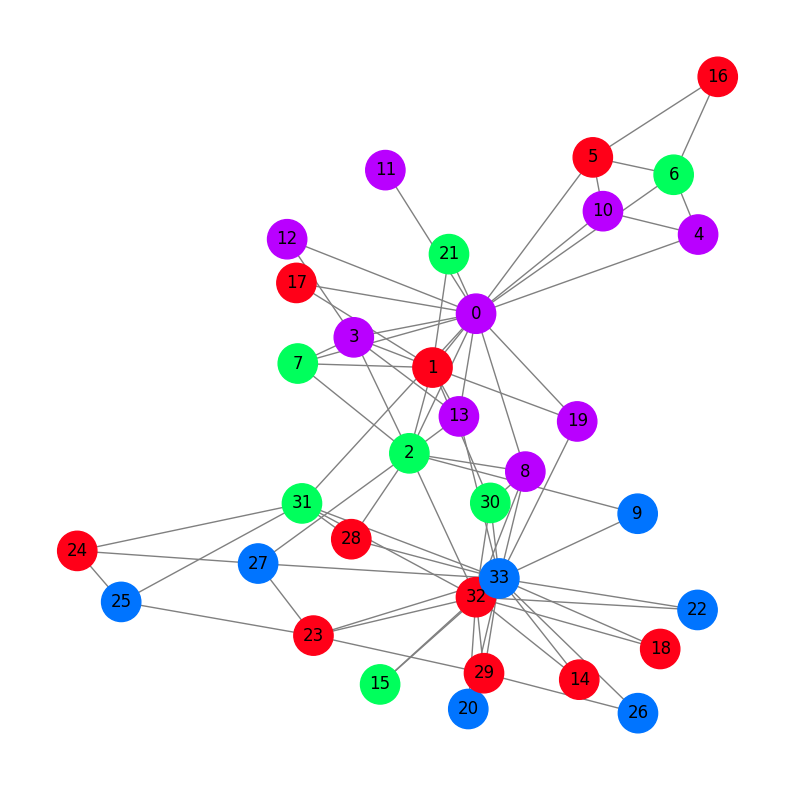

In [58]:
G = to_networkx(data, to_undirected=True)

plt.figure(figsize=(10, 10))
plt.axis('off')
nx.draw_networkx(
    G,
    pos=nx.spring_layout(G, seed=0),
    with_labels=True,
    node_size=800,
    node_color=data.y.numpy(),
    cmap="hsv",
    vmin=-2,
    vmax=num_countries - 1,
    edge_color="gray"
)
plt.show()


In [62]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv

class OptimizedGCN(torch.nn.Module):
    def __init__(self, in_features, hidden_dim, num_classes, dropout_rate=0.2):
        super().__init__()
        self.conv1 = GCNConv(in_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.out = Linear(hidden_dim, num_classes)
        self.dropout = Dropout(dropout_rate)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.leaky_relu(h, 0.1)
        h = self.dropout(h)

        h = self.conv2(h, edge_index)
        h = F.leaky_relu(h, 0.1)
        h = self.dropout(h)

        z = self.out(h)
        return h, F.log_softmax(z, dim=1)

# Set hidden_dim to a higher value
model = OptimizedGCN(dataset.num_features, hidden_dim=32, num_classes=num_countries)


In [60]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

def accuracy(preds, labels):
    return (preds == labels).float().mean().item()


In [69]:
# Training Loop
epochs = 200
embeddings = []
losses = []
accuracies = []
outputs = []

for epoch in tqdm(range(epochs), desc="Training Progress"):
    model.train()
    optimizer.zero_grad()

    h, z = model(data.x, data.edge_index)
    loss = criterion(z, data.y)
    acc = accuracy(z.argmax(dim=1), data.y)

    loss.backward()
    optimizer.step()

    embeddings.append(h.detach().cpu().numpy())
    losses.append(loss.item())
    accuracies.append(acc)
    outputs.append(z.argmax(dim=1).detach().cpu().numpy())

    if epoch % 10 == 0:
      print(f"Epoch {epoch:>3} | Loss: {loss.item():.4f} | Accuracy: {acc * 100:.2f}%")



Training Progress:  18%|█▊        | 36/200 [00:00<00:00, 355.14it/s]

Epoch   0 | Loss: 0.0724 | Accuracy: 100.00%
Epoch  10 | Loss: 0.0277 | Accuracy: 100.00%
Epoch  20 | Loss: 0.0476 | Accuracy: 100.00%
Epoch  30 | Loss: 0.0477 | Accuracy: 100.00%
Epoch  40 | Loss: 0.1193 | Accuracy: 94.12%
Epoch  50 | Loss: 0.0218 | Accuracy: 100.00%
Epoch  60 | Loss: 0.0611 | Accuracy: 97.06%


Training Progress:  54%|█████▎    | 107/200 [00:00<00:00, 340.02it/s]

Epoch  70 | Loss: 0.0258 | Accuracy: 100.00%
Epoch  80 | Loss: 0.0965 | Accuracy: 94.12%
Epoch  90 | Loss: 0.0176 | Accuracy: 100.00%
Epoch 100 | Loss: 0.0217 | Accuracy: 100.00%
Epoch 110 | Loss: 0.0315 | Accuracy: 100.00%
Epoch 120 | Loss: 0.0235 | Accuracy: 100.00%
Epoch 130 | Loss: 0.0480 | Accuracy: 97.06%


Training Progress: 100%|██████████| 200/200 [00:00<00:00, 347.56it/s]

Epoch 140 | Loss: 0.0199 | Accuracy: 100.00%
Epoch 150 | Loss: 0.0195 | Accuracy: 100.00%
Epoch 160 | Loss: 0.0217 | Accuracy: 100.00%
Epoch 170 | Loss: 0.0403 | Accuracy: 97.06%
Epoch 180 | Loss: 0.0306 | Accuracy: 100.00%
Epoch 190 | Loss: 0.0224 | Accuracy: 100.00%


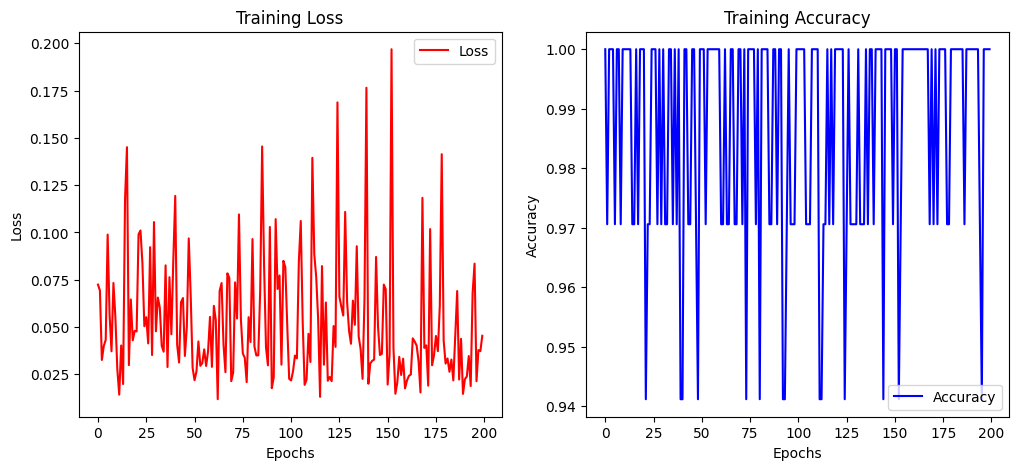

In [70]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses, label="Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label="Accuracy", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()

plt.show()

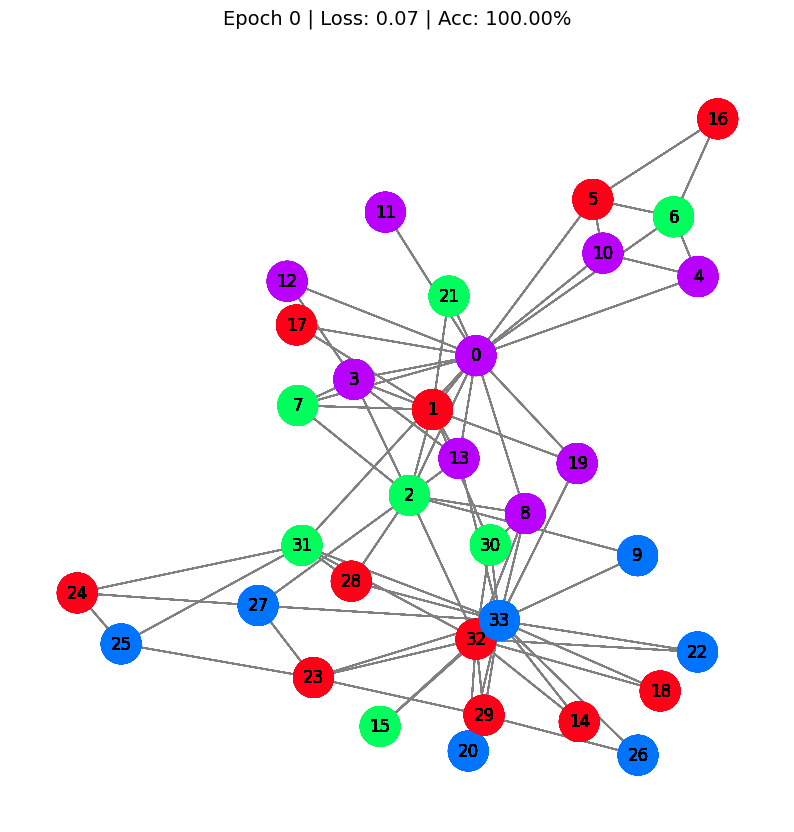

In [72]:
from IPython.display import HTML
from matplotlib import animation

plt.rcParams["animation.bitrate"] = 3000

def animate(i):
    G = to_networkx(data, to_undirected=True)
    nx.draw_networkx(G,
                     pos=nx.spring_layout(G, seed=0),
                     with_labels=True,
                     node_size=800,
                     node_color=outputs[i],
                     cmap="hsv",
                     vmin=-2,
                     vmax=num_countries - 1,
                     edge_color="gray")
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=14, pad=20)

fig = plt.figure(figsize=(10, 10))
plt.axis('off')

anim = animation.FuncAnimation(fig, animate, np.arange(0, 200, 10), interval=500, repeat=True)
html = HTML(anim.to_html5_video())
display(html)


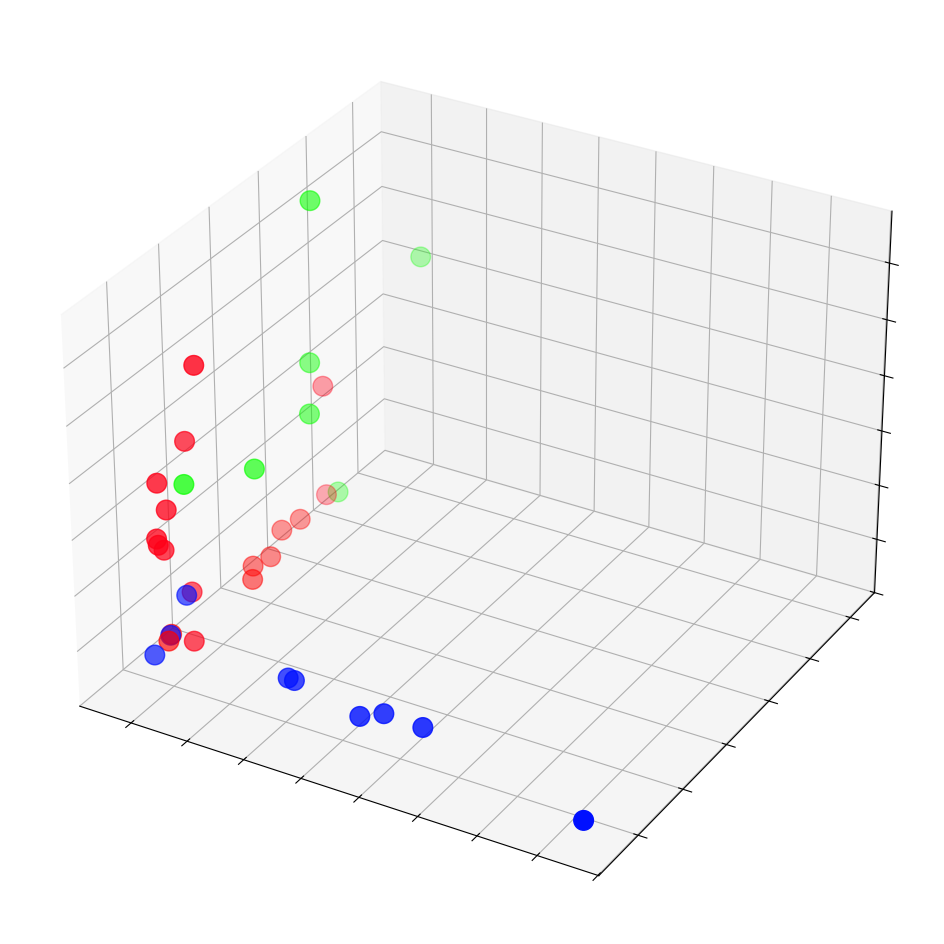

In [73]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.patch.set_alpha(0)
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

ax.scatter(embeddings[-1][:, 0], embeddings[-1][:, 1], embeddings[-1][:, 2],
           s=200, c=data.y.numpy(), cmap="hsv", vmin=0, vmax=num_countries - 1)

plt.show()
